In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import glob

In [3]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
def get_cluster(workers=30,project = 'P93300641'):

    cluster = PBSCluster(
        cores=1, # The number of cores you want
        memory='10GB', # Amount of memory
        processes=1, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        local_directory='$TMPDIR', # Use your local directory
        resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
        account=project, # Input your project ID here
        walltime='01:00:00', # Amount of wall time
    )
    
    # Scale up
    cluster.scale(workers)
    
    # Setup your client
    client = Client(cluster)
    return client

In [4]:
client=get_cluster()

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45923 instead
  warnings.warn(


In [2]:
def fix_time(ds):
    yr0=str(ds['time.year'][0].values)
    ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS',calendar='noleap')
    return ds

In [3]:
def amean(da):
    #annual mean
    m  = da['time.daysinmonth']
    xa = 1/365*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    xa.attrs=da.attrs
    return xa

In [7]:
def gmean(da,la):
    if 'gridcell' in da.dims:
        dim='gridcell'
    else:
        dim=['lat','lon']
    x=(da*la).sum(dim=dim)/la.sum()
    x.attrs=da.attrs
    return x.compute()

In [9]:
def preprocess(ds):
    dvs=['TLAI','TWS','GPP','NPP','TOTVEGC','TOTSOMC','TOTECOSYSC']
    return ds[dvs]

In [10]:
def get_files(case,keys=[],id='oaat'):
    if case=='postSASU':
        s='/glade/derecho/scratch/djk2120/postp/ppe/ctsm5.3.0/postsasu/'
    else:
        s='/glade/derecho/scratch/linnia/'
        
    if not keys:
        if case=='postSASU':
            c='*'
        else:
            if case=='HIST':
                c='ctsm5.3.0_transient_'+id+'*'
            else:
                c='ctsm5.3.0_transient_'+case+'_'+id+'*'
        keys=[d.split('_')[-1].split('.')[0] for d in sorted(glob.glob(s+c))]
    files=[]
    nfiles=0
    goodkeys=[]
    for k in keys:
        if case=='postSASU':
            m='*'
        else:
            m='/run/*.h0.*'
        if case=='HIST':
            c='ctsm5.3.0_transient_'+k
        else:
            c='ctsm5.3.0_transient_'+case+'_'+k
        d=s+c
        f=sorted(glob.glob(d+m))
        if not nfiles:
            nfiles=len(f)
        if len(f)==nfiles:
            files.append(f)
            goodkeys.append(k)
        else:
            print(case,k,len(f),'files')
    return files,goodkeys
        
        

In [11]:
def get_case(case,inits,monthly):
    files,keys=get_files(case)

    
    ds=xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                     preprocess=preprocess,decode_times=False,parallel=True)
    ds['ens']=keys

    if monthly[case]:
        ds['time']=xr.cftime_range(str(inits[case]),periods=len(ds.time),freq='MS',calendar='noleap')
        ds=xr.Dataset({v:amean(ds[v]) for v in ds.data_vars})
    else:
        ds=ds.isel(time=range(1,len(ds.time)))
        ds['year']=xr.DataArray(range(inits[case],inits[case]+len(ds.time)),dims='time')
        ds=ds.swap_dims({'time':'year'})
        
    return ds

In [ ]:
la=xr.open_dataset('/glade/u/home/djk2120/ppe_clean/pyth/sparsegrid_landarea.nc').landarea
inits={'AD':1710,'SASU':1730,'postSASU':1810,'HIST':1850}
monthly={'AD':False,'SASU':False,'postSASU':False,'HIST':True}

In [12]:
files,keys=get_files('postSASU')

In [ ]:
cases=['AD','SASU','postSASU']
dsets={c:get_case(c,inits,monthly) for c in cases}

In [14]:
#separate code for reading the transient data for oaat0057
files=get_files('HIST',keys=['oaat0057'])[0][0]
def pp(ds):
    return ds[['GPP','TOTVEGC','TOTECOSYSC']]
dst=fix_time(xr.open_mfdataset(files,combine='by_coords',parallel=True,preprocess=pp))
gppt=24*60*60*365*1e-9*la.sum()*gmean(amean(dst.GPP),la)

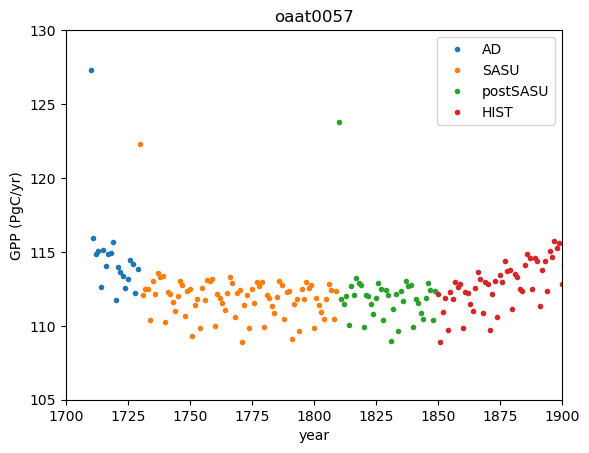

In [144]:
cf=24*60*60*365*1e-9*la.sum()
k='oaat0057'
for case in dsets:
    gpp=cf*gmean(dsets[case].GPP.sel(ens=k),la)
    gpp.plot.line('.',label=case)
gppt.plot.line('.',label='HIST')
plt.xlim([1700,1900])
plt.ylim([105,130])
plt.legend()
plt.title(k)
plt.ylabel('GPP (PgC/yr)');
plt.savefig('figs/oaat0057_gppg_spinup.png',dpi=300,bbox_inches='tight')

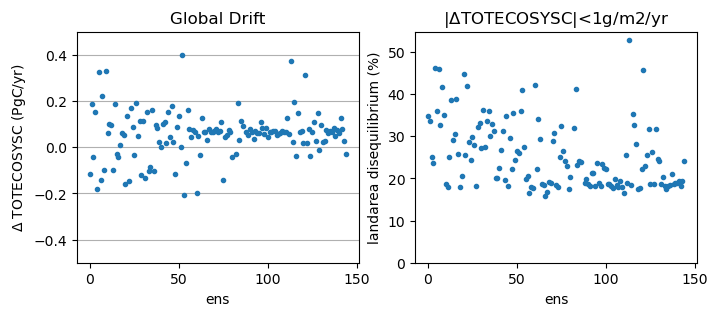

In [31]:
grams=1
x=dsets['postSASU'].TOTECOSYSC
ees=[int(ee[4:]) for ee in x.ens.values]
dx=(x-x.shift(year=20))

plt.figure(figsize=[8,3])

plt.subplot(121)
drift=1e-9*(la*dx.isel(year=range(30,40)).mean(dim='year')).sum(dim='gridcell')/20
plt.plot(ees,drift,'.')
plt.ylim([-0.5,0.5])
plt.grid(axis='y')
plt.xlabel('ens')
plt.ylabel('$\Delta$ TOTECOSYSC (PgC/yr)')
plt.title('Global Drift')

plt.subplot(122)

diseq=100*(la*(abs(dx.isel(year=range(30,40)).mean(dim='year'))>20*grams)).sum(dim='gridcell')/la.sum()
plt.plot(ees,diseq,'.')
plt.xlabel('ens')
plt.ylabel('landarea disequilibrium (%)')
plt.ylim(bottom=0)
plt.title('|$\Delta$TOTECOSYSC|<'+str(grams)+'g/m2/yr')
plt.savefig('figs/spinup_stability.png',dpi=300,bbox_inches='tight');

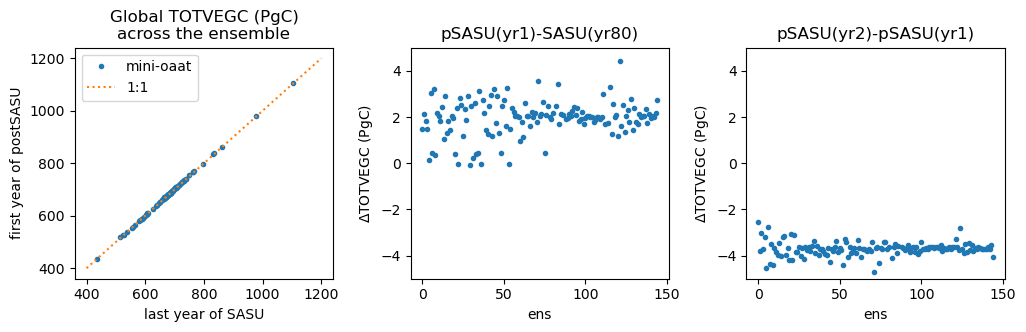

In [53]:
plt.figure(figsize=[12,3])
plt.subplot(131)
x=1e-9*(la*dsets['SASU'].TOTVEGC.isel(year=-1)).sum(dim='gridcell')
y=1e-9*(la*dsets['postSASU'].TOTVEGC.isel(year=0)).sum(dim='gridcell')
ees=[int(ee[4:]) for ee in y.ens.values]
plt.plot(x.sel(ens=y.ens),y,'.',label='mini-oaat')
yy=[400,1200]
plt.plot(yy,yy,':',label='1:1')
plt.xlabel('last year of SASU')
plt.ylabel('first year of postSASU')
plt.title('Global TOTVEGC (PgC)\nacross the ensemble')
plt.legend()
plt.subplot(132)
plt.plot(ees,y-x,'.')
plt.ylabel('$\Delta$TOTVEGC (PgC)')
plt.xlabel('ens')
plt.title('pSASU(yr1)-SASU(yr80)');
plt.ylim([-5,5])

plt.subplot(133)
y2=1e-9*(la*dsets['postSASU'].TOTVEGC.isel(year=1)).sum(dim='gridcell')
plt.plot(ees,y2-y,'.')
plt.ylabel('$\Delta$TOTVEGC (PgC)')
plt.xlabel('ens')
plt.title('pSASU(yr2)-pSASU(yr1)');
plt.ylim([-5,5]);
plt.subplots_adjust(wspace=0.3)

plt.savefig('figs/TVC_jumps.png',dpi=300,bbox_inches='tight')

In [113]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

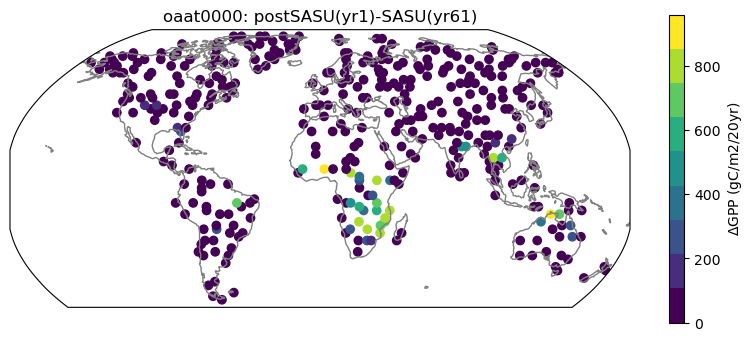

In [133]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson()) 
extent = [-180, 180,-60,90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(color='grey')

dx=abs(gpp.sel(year=1810)-gpp.sel(year=1790))
sc=ax.scatter(tmp.grid1d_lon,tmp.grid1d_lat,c=dx,
           transform=ccrs.PlateCarree(),cmap=cmap)
plt.colorbar(sc,label='$\Delta$GPP (gC/m2/20yr)')
plt.title(k+': postSASU(yr1)-SASU(yr61)');
plt.savefig('figs/'+k+'_gppjump_gridded.png',dpi=300,bbox_inches='tight');

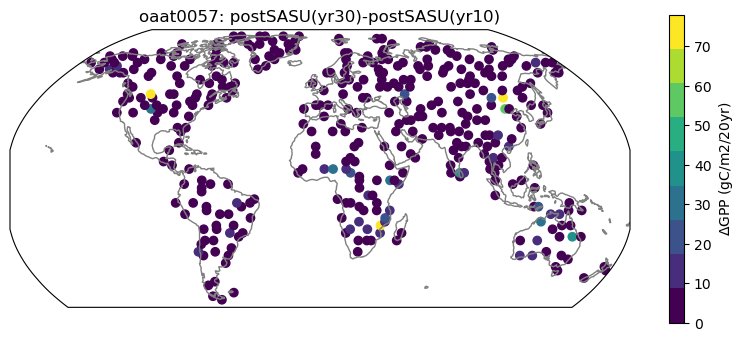

In [131]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson()) 
extent = [-180, 180,-60,90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(color='grey')

dx=abs(gpp.sel(year=1840)-gpp.sel(year=1820))
sc=ax.scatter(tmp.grid1d_lon,tmp.grid1d_lat,c=dx,
           transform=ccrs.PlateCarree(),cmap=cmap)
plt.colorbar(sc,label='$\Delta$GPP (gC/m2/20yr)')
plt.title(k+': postSASU(yr30)-postSASU(yr10)');
plt.savefig('figs/oaat0057_gpp_nojump_gridded.png',dpi=300,bbox_inches='tight');

### pft-level output
 - from a double spinup

In [7]:
d='/glade/derecho/scratch/linnia/ctsm5.3.0_transient_postSASU_test0010/run/'
files=sorted(glob.glob(d+'*.clm2.h1.*'))
ds=xr.open_mfdataset(files,combine='by_coords')
ds['time']=xr.cftime_range('2000',periods=len(ds.time),freq='MS',calendar='noleap')

In [ ]:
d='/glade/derecho/scratch/linnia/ctsm5.3.0_transient_SASU_test0010/run/'
files=sorted(glob.glob(d+'*.clm2.h1.*'))
ds0=xr.open_mfdataset(files,combine='by_coords')
ds0['time']=xr.cftime_range('2000',periods=len(ds0.time),freq='MS',calendar='noleap')

In [47]:
cfs={'TLAI':1,'TOTVEGC':1,'GPP':24*60*60*365}

In [48]:
xs={'SASU':{},'pSASU':{}}
for dset,c in zip([ds0,ds],xs):
    for v in ['TLAI','TOTVEGC','GPP']:
        xs[c][v]=cfs[v]*amean(dset[v])
    
        

In [54]:
ds.pfts1d_wtgcell.isel(time=0)

<xarray.DataArray 'pfts1d_wtgcell' (pft: 3978)>
dask.array<getitem, shape=(3978,), dtype=float64, chunksize=(3978,), chunktype=numpy.ndarray>
Coordinates:
    time     object 2000-01-01 00:00:00
Dimensions without coordinates: pft
Attributes:
    long_name:  pft weight relative to corresponding gridcell

In [75]:
lat=ds.pfts1d_lat.isel(time=0)
aa=ds.pfts1d_wtgcell.isel(time=0)*np.cos(np.deg2rad(lat))

In [84]:
dx=xs['pSASU'][v].isel(year=0)-xs['SASU'][v].isel(year=-1)
fromdead=(aa*dx).isel(pft=ixdead).sum()/(aa*dx).sum()
fromdead.values

array(1.03787101)

In [85]:
ixp=dx.argmax()

In [102]:
ds.pfts1d_itype_veg.isel(time=0,pft=ixp).values

array(4.)

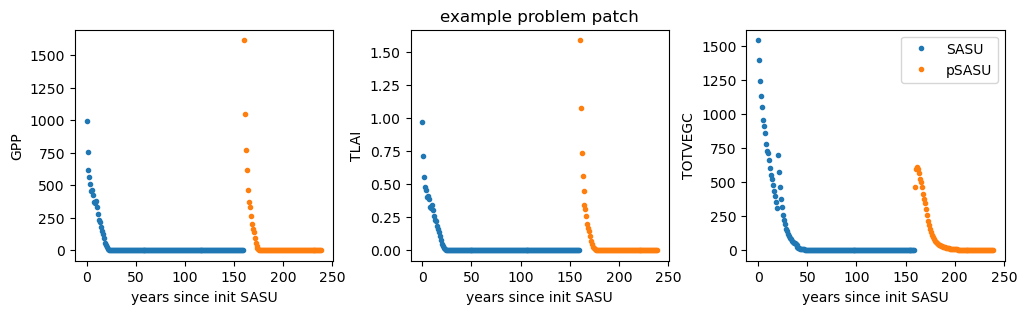

In [105]:
plt.figure(figsize=[12,3])
for i,v in enumerate(['GPP','TLAI','TOTVEGC']):
    plt.subplot(131+i)
    plt.plot(range(160),xs['SASU'][v].isel(pft=ixp),'.',label='SASU')
    plt.plot(range(160,240),xs['pSASU'][v].isel(pft=ixp),'.',label='pSASU')
    plt.xlabel('years since init SASU')
    plt.ylabel(v)
    if i==1:
        plt.title('example problem patch')
    if i==2:
        plt.legend()
    plt.savefig('figs/patch500_ts.png',dpi=300,bbox_inches='tight');
plt.subplots_adjust(wspace=0.3)

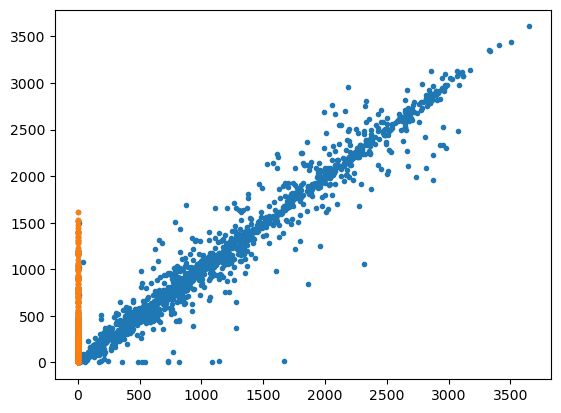

In [64]:
v='GPP'
ixdead=(xs['SASU'][v].isel(year=-1)==0).compute()
plt.plot(xs['SASU'][v].isel(year=-1),
         xs['pSASU'][v].isel(year=0),'.')

plt.plot(xs['SASU'][v].isel(pft=ixdead,year=-1),
         xs['pSASU'][v].isel(pft=ixdead,year=0),'.')

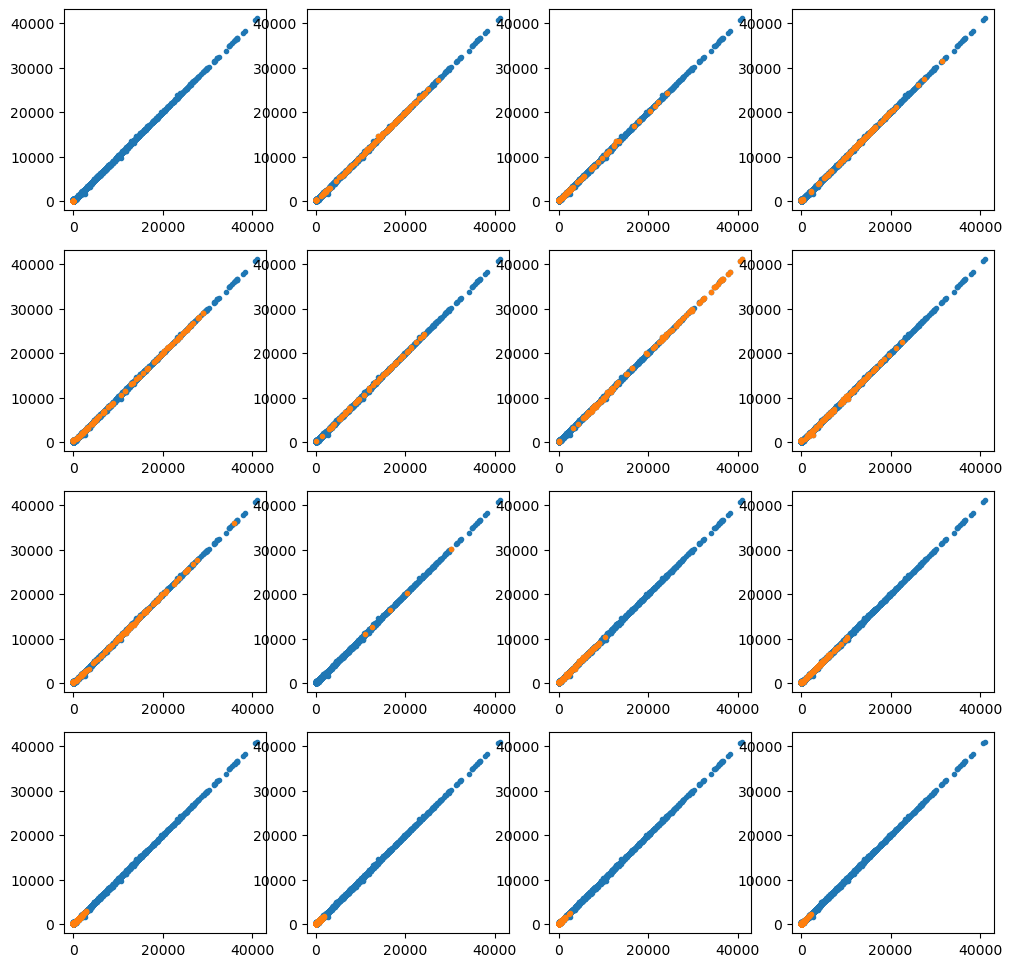

In [56]:
v='TOTVEGC'
plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(xs['SASU'][v].isel(year=-1),
             xs['pSASU'][v].isel(year=0),'.')
    ix=(ds.pfts1d_itype_veg.isel(time=0)==i).compute()
    plt.plot(xs['SASU'][v].isel(pft=ix,year=-1),
             xs['pSASU'][v].isel(pft=ix,year=0),'.')
